In [1]:
# load packages required for analysis
#install.packages("")
#BiocManager::install("")

# load packages required for analysis
library(tidyverse)
library(knitr)
library(limma)
library(minfi)
library(RColorBrewer)
library(missMethyl)
library(Gviz)
library(DMRcate)
library(stringr)
library(IlluminaHumanMethylationEPICmanifest)
library(IlluminaHumanMethylationEPICanno.ilm10b4.hg19)
library(ggplot2)
library(ggpubr)
library(wateRmelon)
library(repr)
library(MethylToSNP)

print("done loading packages")

── Attaching packages ───────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ──────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, m

[1] "done loading packages"


In [2]:
### import necessary variables
project_master_dir = "/stg3/data2/resource3/project/RA-TIP-CS"

# input
metadata_fp = paste0(project_master_dir, "/Data/Metadata/TIP-CS_metadata_HIPAAcomp.csv")
crossReactiveProbes_fp = paste0(project_master_dir, "/Data/Processing/13059_2016_1066_MOESM1_ESM.csv")

# output
dir.create(file.path(paste0(project_master_dir,"/Data")), showWarnings = FALSE)

dataQC_output_dir = paste0(project_master_dir,"/Data/QualityControl_Output")
dir.create(file.path(dataQC_output_dir), showWarnings = FALSE)

dataObjs_output_dir = paste0(project_master_dir,"/Data/Processed_Data")
dir.create(file.path(dataObjs_output_dir), showWarnings = FALSE)

dataLog_fp = paste0(dataObjs_output_dir, "/dataLog.txt")

In [3]:
### Import data with minfi
# define metadata file; metadata file serves as minfi object
metadata_df = read.csv(metadata_fp, sep = "\t")
methArray_sheet_obj = metadata_df

# read in the sample sheet for the experiment
rgSet_obj = read.metharray.exp(targets=methArray_sheet_obj, extended=TRUE, force=TRUE, verbose = FALSE)

# get the annotation data
anno_data = getAnnotation(IlluminaHumanMethylationEPICanno.ilm10b4.hg19)

# give the samples descriptive names
sampleNames(rgSet_obj) = methArray_sheet_obj$unique_id

Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
Warning message in readChar(con, nchars = n):
"truncating string 

In [4]:
### Perform raw data processing
# take dataset and create raw MethylSet object
mSet_raw_obj = preprocessRaw(rgSet_obj)

# get meth and unmeth data from object
meth_raw_df = getMeth(mSet_raw_obj)
unMeth_raw_df = getUnmeth(mSet_raw_obj)

# get beta and M values from object
beta_raw_df = getBeta(mSet_raw_obj)

# get qc data from the object
qc_raw_df = getQC(mSet_raw_obj)

# get beadcount data from the rgSet_obj
bc_raw_df = beadcount(rgSet_obj)

In [5]:
### Quality Control, Part 1, P-Value QC
# calculate the detection p-values
detectionPval_df = detectionP(rgSet_obj)

# set cutoffs
pval_cutoff = 0.05
failcount_pct = 0.01

failcount_sample_cutoff = dim(meth_raw_df)[1]*failcount_pct
failcount_probe_cutoff = dim(meth_raw_df)[2]*failcount_pct

# create dataframes showing data quality of samples and probes
# by sample
samplePval_df = data.frame(sample=colnames(detectionPval_df), 
                           cell_type=as.vector(unlist(lapply(strsplit(colnames(detectionPval_df), split = "_", fixed = T), function(x) x[length(x) -3]))), 
                           failcount_bySample=apply(detectionPval_df, 2, function(x) sum(x>pval_cutoff)))
samplePval_df = samplePval_df[order(samplePval_df$cell_type, -samplePval_df$failcount_bySample),]
samplePval_df$order_var = seq.int(nrow(samplePval_df))
                                                    
# by probe
probePval_df = data.frame(probe=rownames(detectionPval_df), 
                          failcount_byProbe=apply(detectionPval_df, 1, function(x) sum(x>pval_cutoff)))
probePval_df = probePval_df[order(-probePval_df$failcount_byProbe),]
probePval_df$order_var = seq.int(nrow(probePval_df))

# check failure amounts and probes, samples
failedSample_samplePval_vector = rownames(samplePval_df[samplePval_df$failcount_bySample > failcount_sample_cutoff, ])
failedSample_samplePval_text = paste0(length(failedSample_samplePval_vector), " of ", dim(samplePval_df)[1], " samples failed probe p-value QC")
                                                                            
failedProbe_probePval_vector = rownames(probePval_df[probePval_df$failcount_byProbe > failcount_probe_cutoff, ])
failedProbe_probePval_text = paste0(length(failedProbe_probePval_vector), " of ", dim(probePval_df)[1], " probes failed probe p-value QC")

# visualize
probePval_hist = ggplot(probePval_df, aes(x=failcount_byProbe)) + 
    geom_histogram(binwidth=1) + 
    geom_vline(aes(xintercept=failcount_probe_cutoff)) + 
    theme(legend.position="none") + 
    labs(title= paste0("Histogram of Failed Sample Count by Probe"), 
         x = paste0("Number of Samples with P-Value > ", pval_cutoff), 
         y = paste0("Probe Count")) + 
    coord_cartesian(xlim = c(0, 10)) 

samplePval_hist = ggplot(samplePval_df, aes(x=failcount_bySample, fill = cell_type)) + 
    geom_histogram(binwidth=100) + 
    geom_vline(aes(xintercept=failcount_sample_cutoff)) + 
    theme(legend.position="none") + 
    labs(title= paste0("Histogram of Failed Probe Count by Sample"), 
         x = paste0("Number of Probes with P-Value > ", pval_cutoff), 
         y = paste0("Sample Count")) +
    coord_cartesian(xlim = c(0, 9000)) 
                                                  
# output individual
png(paste0(dataQC_output_dir, "/RA.TIP.CS_sampleDetPval_hist.png"), width = 6, height = 4, res = 1200, units = "in")
samplePval_hist
dev.off()

png(paste0(dataQC_output_dir, "/RA.TIP.CS_probeDetPval_hist.png"), width = 6, height = 4, res = 1200, units = "in")
probePval_hist
dev.off()


png 
  2

png 
  2

In [6]:
rm(meth_raw_df)
rm(unMeth_raw_df)
rm(probePval_df)
rm(probePval_hist)
rm(metadata_df)
rm(methArray_sheet_obj)
rm(project_master_dir)
rm(detectionPval_df)
rm(metadata_fp)
rm(failedProbe_probePval_vector)
rm(qc_raw_df)
rm(failedSample_samplePval_vector)
rm(samplePval_df)
rm(samplePval_hist)
gc()


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,22362189,1194.3,43019614,2297.5,43019614,2297.5
Vcells,2242437044,17108.5,5559291824,42414.1,5559268174,42413.9


DataFrame with 10 rows and 2 columns
                       mMed      uMed
                  <numeric> <numeric>
p41_ls39_B_CCPpos   11.2831   10.3750
p38_ls29_B_CCPneg   11.3848   10.2143
p11_ls4_B_CCPneg    11.2917   10.6312
p60_ls53_B_ERA      11.2070   10.5187
p24_ls27_B_CCPneg   11.4878   10.8289
p4_ls9_B_CCPpos     11.5488   10.8074
p65_ls66_B_CCPneg   11.4564   10.6357
p54_ls71_B_CCPneg   11.6008   10.5479
p42_ls36_B_CCPpos   11.6253   10.5469
p18_ls19_B_CCPneg   11.1861   10.7372

[1] "p20_ls23_Tnai_CCPpos failed methylation/unmethylation signal intensity ratio QC"

png 
  2

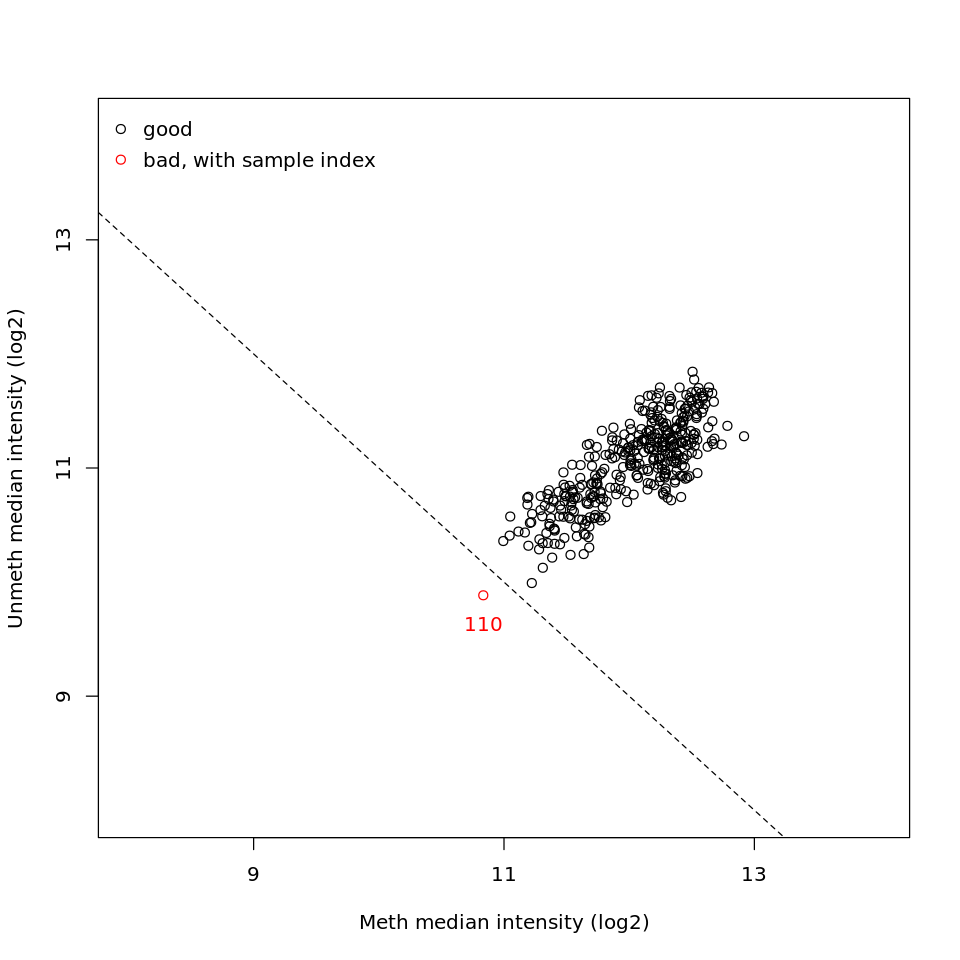

In [7]:
### Quality Control, Part 2, meth signal intensity ratio
# get qc data
meth_signal_qcData = getQC(mSet_raw_obj)
head(meth_signal_qcData, n=10)

# define failed samples
meth_signal_cutoff = 10.5

meth_signal_qcData$avg = apply(meth_signal_qcData, 1, mean)

meth_signal_qcFail_vector = rownames(meth_signal_qcData[meth_signal_qcData$avg < meth_signal_cutoff, ])
meth_signal_qcFail_text = paste0(meth_signal_qcFail_vector, " failed methylation/unmethylation signal intensity ratio QC")
meth_signal_qcFail_text

# plot qc data on jupyter
options(repr.plot.width=8, repr.plot.height=8)
plotQC(meth_signal_qcData)

setwd(dataQC_output_dir)
png(paste0(dataQC_output_dir,"/RA.TIP.CS_methIntensity_plot.png"), width = 8, height = 8, res = 1200, units = "in")
plotQC(meth_signal_qcData)
dev.off()


In [8]:
rm(mSet_raw_obj)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,22376013,1195.1,43019614,2297.5,43019614,2297.5
Vcells,1911709295,14585.2,5559291824,42414.1,5559268174,42413.9


,p41_ls39_B_CCPpos,p38_ls29_B_CCPneg,p11_ls4_B_CCPneg,p60_ls53_B_ERA,p24_ls27_B_CCPneg,p4_ls9_B_CCPpos,p65_ls66_B_CCPneg,p54_ls71_B_CCPneg,p42_ls36_B_CCPpos,p18_ls19_B_CCPneg,⋯,p109_ls109_Tmem_ERA,p66_ls57_Tnai_CCPpos,p125_ls124_Tnai_ERA,p75_ls75_B_CCPneg,p28_ls21_Tnai_CCPneg,p83_ls89_Tnai_CCPpos,p93_ls92_B_CCPpos,p119_ls119_Tnai_CCPpos,p119_ls119_Tmem_CCPpos,p119_ls119_B_CCPpos
cg05403241,0.51753805,0.4505724,0.46448657,0.44693754,0.50898328,0.42310586,0.45860506,0.49135086,0.45925056,0.45641660,⋯,0.57765743,0.38365185,0.37332607,0.44235624,0.38992025,0.50442078,0.46554041,0.57204578,0.51432674,0.54232329
cg05774358,0.68823994,0.7886558,0.60298778,0.68021928,0.69886985,0.69274448,0.73451033,0.78066528,0.76016830,0.59269044,⋯,0.71345515,0.79559055,0.87462052,0.68831471,0.86636872,0.87435495,0.72431132,0.86913788,0.78081167,0.82074024
cg09222884,0.62087912,0.7309501,0.58690579,0.65277054,0.57571391,0.67329545,0.67004505,0.71532295,0.72219992,0.65851710,⋯,0.73929702,0.71007974,0.76049307,0.64713610,0.80917809,0.80180031,0.65614219,0.82508889,0.78114676,0.74913658
cg21184257,0.59869622,0.6778279,0.58488613,0.60120022,0.58205363,0.58429695,0.62053912,0.64341761,0.63687332,0.53347143,⋯,0.66431770,0.64281335,0.66203994,0.59837050,0.71507717,0.69468628,0.58488130,0.74283202,0.69423359,0.68392759
cg25020293,0.68930997,0.7885102,0.66950380,0.73744292,0.68060174,0.68003398,0.71080014,0.76993569,0.79872611,0.59557134,⋯,0.70371405,0.72667198,0.72425482,0.72344771,0.75607423,0.72627015,0.61875202,0.79768829,0.74435886,0.75667465
cg04076682,0.02821113,0.0273594,0.02170158,0.02024576,0.03488372,0.02175777,0.02802604,0.03036649,0.02508396,0.02283246,⋯,0.03755339,0.02828658,0.03007519,0.03547452,0.03247766,0.04602373,0.02601849,0.06255807,0.05479794,0.03518103


png 
  2

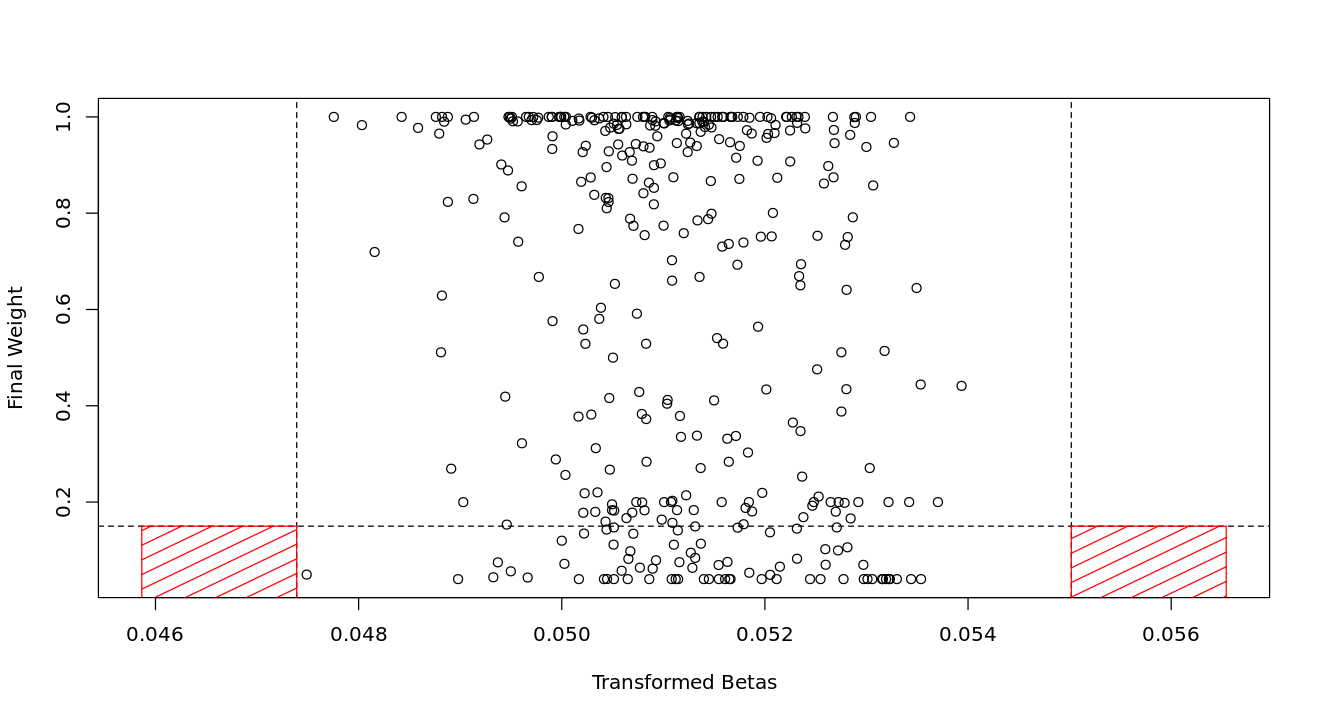

In [9]:
### Quality Control, Part 3, Beta outlier QC
# downsampled dataset for plotting
downsample_pct=1.00
set.seed(10)

beta_raw_sdf = beta_raw_df[sample(nrow(beta_raw_df), dim(beta_raw_df)[1]*downsample_pct),]
head(beta_raw_sdf)

# plot chart on jupyter
options(repr.plot.width=11, repr.plot.height=6)
outliers_wobj = outlyx(beta_raw_sdf, plot = TRUE)

# output to directory
setwd(dataQC_output_dir)
png(paste0(dataQC_output_dir,"/RA.TIP.CS_sampleOutlier_dp.png"), width = 11, height = 6, res = 1200, units = "in")
outliers_wobj = outlyx(beta_raw_sdf, plot = TRUE)
dev.off()

In [10]:
rm(beta_raw_df)
rm(beta_raw_sdf)
rm(outliers_wobj)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,22383211,1195.4,43019614,2297.5,43019614,2297.5
Vcells,1580100306,12055.3,5336984151,40718.0,5559291513,42414.1


[1] "1 of 382, p20_ls23_Tnai_CCPpos, failed bisulfite conversion QC"

Warning message:
"Removed 2 rows containing missing values (`geom_bar()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_bar()`)."


png 
  2

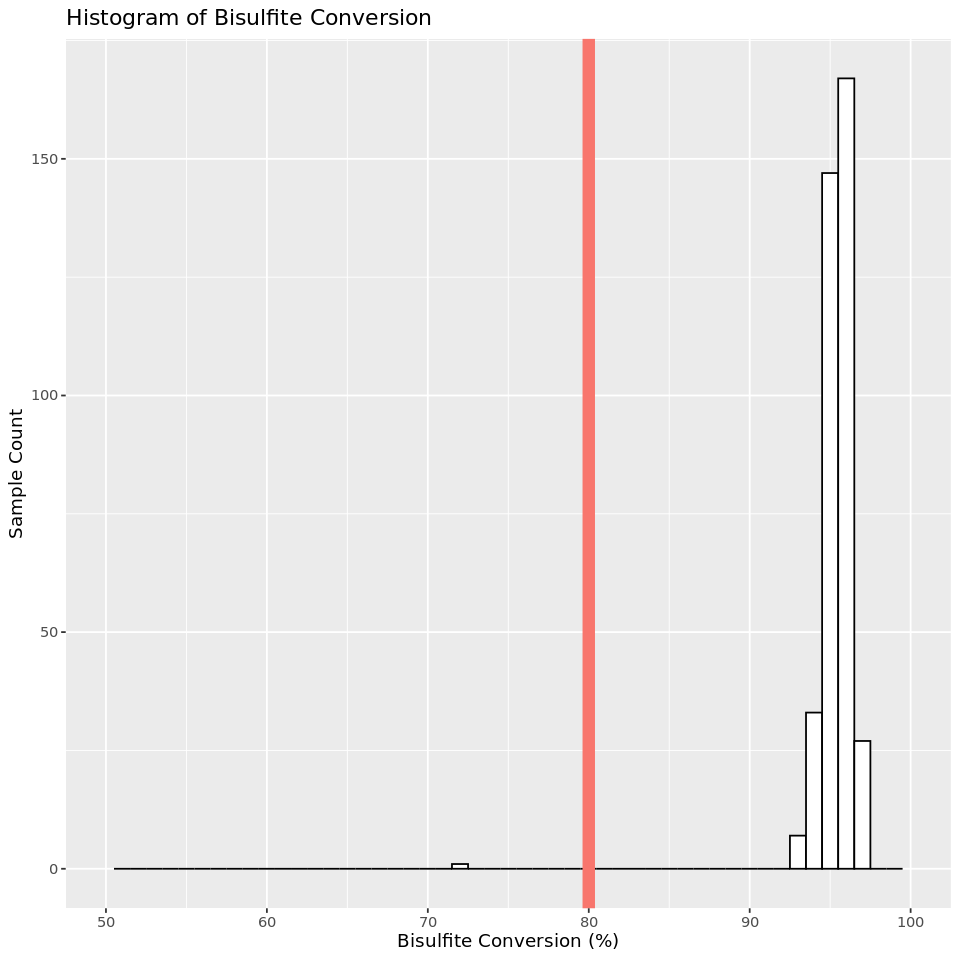

In [11]:
### Quality Control, Part 4, Bisulfite conversion QC
bsc_cutoff = 80
# create bisulfite conversion plot
bsc_vector = bscon(rgSet_obj)
bsc_df = data.frame(bsc_vals = bsc_vector)
bsc_df$sample = rownames(bsc_df)
rownames(bsc_df) = NULL
bsc_df$sample = as.factor(bsc_df$sample)
bsc_df$bsc_vals = as.numeric(bsc_df$bsc_vals)

# identified failed samples
failedSamples_bsc_vector = bsc_df[bsc_df$bsc_vals < bsc_cutoff, "sample"]
failedSamples_bsc_text = paste0(length(failedSamples_bsc_vector), " of ", length(bsc_vector),", ", failedSamples_bsc_vector, ", failed bisulfite conversion QC")
failedSamples_bsc_text

# create plot
bsc_hist = ggplot(bsc_df, aes(x=bsc_vals)) + 
    geom_histogram(binwidth=1,color="black", fill="white") + 
    geom_vline(aes(xintercept=bsc_cutoff, color="red", linetype="dashed", linewidth=1)) + 
    theme(legend.position="none") + 
    labs(title= paste0("Histogram of Bisulfite Conversion"), y= "Sample Count", x = "Bisulfite Conversion (%)") + 
    scale_x_continuous(limits = c(50, 100))

# plot chart on jupyter
options(repr.plot.width=8, repr.plot.height=8)
bsc_hist

# output to directory
png(paste0(dataQC_output_dir, "/RA.TIP.CS_bsc_hist.png"), width = 8, height = 8, res = 1200, units = "in")
bsc_hist
dev.off()


In [12]:
### Quality Control, Part 5, Beadcount QC
beadcount_cutoff = 3
beadcount_sample_pct = 0.05
beadcount_sample_cutoff = dim(bc_raw_df)[2]*beadcount_sample_pct

# identified failed samples
probes_bcSamplesFailed_vector = rowSums(is.na(bc_raw_df))
probesFailed_bcSamplesFailed_vector = probes_bcSamplesFailed_vector[probes_bcSamplesFailed_vector > beadcount_sample_cutoff]
probesFailed_bcSamplesFailed_text = paste0(length(probesFailed_bcSamplesFailed_vector), " of ", dim(bc_raw_df)[1], " probes failed beadcount QC")
probesFailed_bcSamplesFailed_text

[1] "1834 of 865859 probes failed beadcount QC"

In [13]:
rm(probesFailed_bcSamplesFailed_vector)
rm(bc_raw_df)
rm(probes_bcSamplesFailed_vector)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,22410387,1196.9,43019614,2297.5,43019614,2297.5
Vcells,1246361101,9509.0,4269587321,32574.4,5559291513,42414.1


In [14]:
### Perform filtering, normalization, processing and more filtering of probes and samples
# QC filtering
wm_QCfiltered_obj = pfilter(rgSet_obj, perCount=beadcount_sample_pct*100, pnthresh = pval_cutoff, perc = failcount_pct*100, pthresh = failcount_pct*100, logical.return=TRUE)

mSet_QCfiltered_raw_obj = wm_QCfiltered_obj[,!colnames(wm_QCfiltered_obj) %in% failedSamples_bsc_vector] # this includes removal based on bisulfite conversion < 80%
mSet_QCfiltered_raw_obj = mSet_QCfiltered_raw_obj[,!colnames(mSet_QCfiltered_raw_obj) %in% meth_signal_qcFail_vector] # this includes removal based on meth/unmeth signal intensity ratio

rm(wm_QCfiltered_obj)

# Perform normalization with wateRmelon
mSet_QCfiltered_dasen_obj = dasen(mSet_QCfiltered_raw_obj)

0 samples having 1 % of sites with a detection p-value greater than 0.05 were removed 
Samples removed:  
1834 sites were removed as beadcount <3 in 5 % of samples 
4682 sites having 1 % of samples with a detection p-value greater than 0.05 were removed 


Warning message in dfsfit(mns, onetwo, ...):
"NAs introduced by coercion"
Warning message in dfsfit(mns, onetwo, ...):
"NAs introduced by coercion"
Sentrix position model failed, skipping



In [15]:
rm(mSet_QCfiltered_raw_obj)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,22420301,1197.4,43019614,2297.5,43019614,2297.5
Vcells,1902142572,14512.2,6148381742,46908.5,6148381526,46908.5


In [16]:
### Perform processing on filtered and normalized data
## S4 Rdata objects
# define processed methylSet object
mSet_QCfiltered_dasen_obj = mSet_QCfiltered_dasen_obj

# map to genome to create genomic methylSet object
gmSet_QCfiltered_dasen_obj = mapToGenome(mSet_QCfiltered_dasen_obj)

# create ratioSet object from processed methylSet object
rSet_QCfiltered_dasen_obj = ratioConvert(mSet_QCfiltered_dasen_obj)

# map to genome to create genomic ratioSet object
grSet_QCfiltered_dasen_obj = mapToGenome(rSet_QCfiltered_dasen_obj)

## Dataframes
# get meth and unmeth data from processed methylSet object
meth_QCfiltered_dasen_df = getMeth(mSet_QCfiltered_dasen_obj)
unMeth_QCfiltered_dasen_df = getUnmeth(mSet_QCfiltered_dasen_obj)

# get beta and M values from object
beta_QCfiltered_dasen_df = getBeta(mSet_QCfiltered_dasen_obj)

[MethylToSNP] Optionally, specify SNPs in a data frame with row names corresponding to cg probes (such as SNPs.147CommonSingle in minfiData or minfiDataEPIC package)



[1] "480 potential probes overlapping SNPs identified by methylToSNP"

[1] "325 high-confidence probes overlapping SNPs identified by methylToSNP and removed"

png 
  2

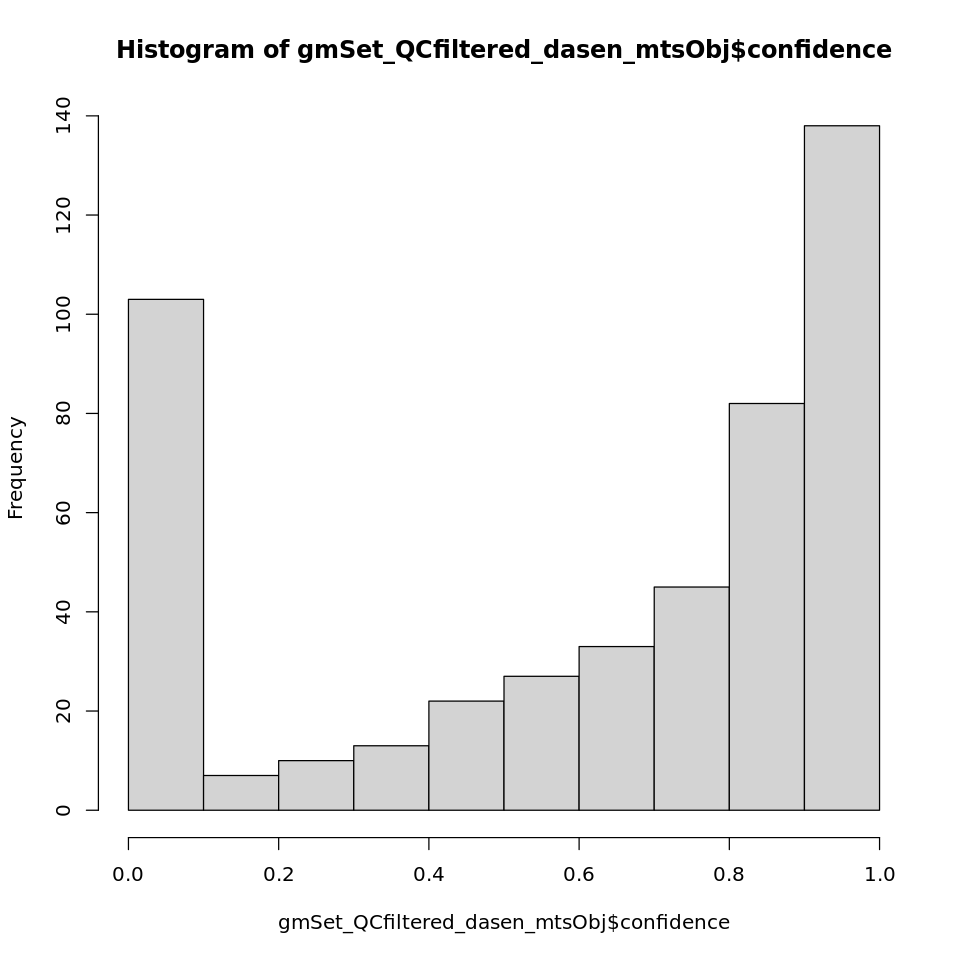

In [17]:
### Perform methylTosnp processing
gmSet_QCfiltered_dasen_mtsObj = MethylToSNP(gmSet_QCfiltered_dasen_obj, gap.ratio = 0.75, gap.sum.ratio = 0.5, verbose = FALSE, outlier.sd = 3)

# apply reliability cutoff
reliability_cutoff = 0.5

methylToSNP_potential_text = paste0(dim(gmSet_QCfiltered_dasen_mtsObj)[1], " potential probes overlapping SNPs identified by methylToSNP")
methylToSNP_potential_text
hist(gmSet_QCfiltered_dasen_mtsObj$confidence)

gmSet_QCfiltered_dasen_mtsObj = gmSet_QCfiltered_dasen_mtsObj[gmSet_QCfiltered_dasen_mtsObj$confidence > 0.5,]
methylToSNP_removed_text = paste0(dim(gmSet_QCfiltered_dasen_mtsObj)[1], " high-confidence probes overlapping SNPs identified by methylToSNP and removed")
methylToSNP_removed_text

# continue filtering probes; remove probes likely located on SNPs
notSNP_keepVector = !(featureNames(gmSet_QCfiltered_dasen_obj) %in% rownames(gmSet_QCfiltered_dasen_mtsObj))
gmSet_snpQCfiltered_dasen_obj = gmSet_QCfiltered_dasen_obj[notSNP_keepVector,]


# output to directory
png(paste0(dataQC_output_dir, "/RA.TIP.CS_methylToSNP_hist.png"), width = 8, height = 8, res = 1200, units = "in")
hist(gmSet_QCfiltered_dasen_mtsObj$confidence)
dev.off()


In [18]:
### Remove common SNPs and cross-reactive probes
# SNPs
preCommonSNPremoval_count = dim(gmSet_snpQCfiltered_dasen_obj)[1]
gmSet_snpQCfiltered_dasen_obj = dropLociWithSnps(gmSet_snpQCfiltered_dasen_obj, snps = c("SBE","CpG"), maf = 0)
postCommonSNPremoval_count = dim(gmSet_snpQCfiltered_dasen_obj)[1]

commonSNPremoval_text = paste0(preCommonSNPremoval_count-postCommonSNPremoval_count, " probes overlapping common SNPs identified and removed")
commonSNPremoval_text

# cross-reactive probes; probe list taken from https://genomebiology.biomedcentral.com/articles/10.1186/s13059-016-1066-1
crossReactiveProbes_df = read.csv(crossReactiveProbes_fp, sep = ",")

notCrossReactive_keepIdx = !(featureNames(gmSet_snpQCfiltered_dasen_obj) %in% crossReactiveProbes_df$X)

preCrossReactiveremoval_count = dim(gmSet_snpQCfiltered_dasen_obj)[1]
gmSet_snpQCfiltered_dasen_obj = gmSet_snpQCfiltered_dasen_obj[notCrossReactive_keepIdx,]
postCrossReactiveremoval_count = dim(gmSet_snpQCfiltered_dasen_obj)[1]

crossReactiveRemoval_text = paste0(preCrossReactiveremoval_count-postCrossReactiveremoval_count, " cross-reactive probes identified and removed")
crossReactiveRemoval_text



[1] "28500 probes overlapping common SNPs identified and removed"

[1] "40682 cross-reactive probes identified and removed"

In [19]:
### Export data objects
setwd(dataObjs_output_dir)

saveRDS(mSet_QCfiltered_dasen_obj,file="01.mSet_QCfiltered_All_dasen.RDS")
saveRDS(gmSet_QCfiltered_dasen_obj,file="02.gmSet_QCfiltered_All_dasen.RDS")
saveRDS(gmSet_snpQCfiltered_dasen_obj,file="02.gmSet_snpQCfiltered_All_dasen.RDS")
saveRDS(rSet_QCfiltered_dasen_obj, file="03.rSet_QCfiltered_All_dasen.RDS")
saveRDS(grSet_QCfiltered_dasen_obj, file="04.grSet_QCfiltered_All_dasen.RDS")

write.table(meth_QCfiltered_dasen_df,"05.meth_QCfiltered_All_dasen.dat",quote=F,sep="\t")
write.table(unMeth_QCfiltered_dasen_df,"06.unMeth_QCfiltered_All_dasen.dat",quote=F,sep="\t")
write.table(beta_QCfiltered_dasen_df,"07.beta_QCfiltered_All_dasen.dat",quote=F,sep="\t")


In [20]:
rm(beta_QCfiltered_dasen_df)
rm(meth_QCfiltered_dasen_df)
rm(unMeth_QCfiltered_dasen_df)
rm(notCrossReactive_keepIdx)
rm(notSNP_keepVector)
rm(crossReactiveProbes_df)
rm(rSet_QCfiltered_dasen_obj)
rm(grSet_QCfiltered_dasen_obj)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,22438055,1198.4,43019614,2297.5,43019614,2297.5
Vcells,3165607589,24151.7,7378138090,56290.8,6443610042,49160.9


In [21]:
### Perform additional filtering on QC-filtered and normalized data
## Remove probes that are locate on sex chromosomes
# map to genome
gmSet_QCfiltered_dasen_obj = mapToGenome(mSet_QCfiltered_dasen_obj)

# continue filtering probes; remove sex chromosome if you are analyzing both male and female samples
notSex_keepVector = !(featureNames(gmSet_QCfiltered_dasen_obj) %in% anno_data$Name[anno_data$chr %in% c("chrX","chrY")])
sexChromProbes_standardQC_text = paste0(summary(notSex_keepVector)[2], " of ", dim(gmSet_QCfiltered_dasen_obj)[1], " probes located on sex chromosome and removed in analysis without regard to SNPs, for autosome analysis")
sexChromProbes_standardQC_text

# create sex-chromosome-probe-filtered genomic methylSet object
gmSet_sexQCfiltered_dasen_obj = gmSet_QCfiltered_dasen_obj[notSex_keepVector,]

# create sex-chromosome-probe-filtered genomic ratioSet object
grSet_sexQCfiltered_dasen_obj = ratioConvert(gmSet_sexQCfiltered_dasen_obj)


## Do the same for the snp removed data
gmSet_snpQCfiltered_dasen_obj = gmSet_snpQCfiltered_dasen_obj

# continue filtering probes; remove sex chromosome if you are analyzing both male and female samples
notSex_keepVector = !(featureNames(gmSet_snpQCfiltered_dasen_obj) %in% anno_data$Name[anno_data$chr %in% c("chrX","chrY")])
sexChromProbes_snpQC_text = paste0(summary(notSex_keepVector)[2], " of ", dim(gmSet_snpQCfiltered_dasen_obj)[1], " probes located on sex chromosome and removed in analysis post-SNP QC, for autosome analysis")
sexChromProbes_snpQC_text

# create sex-chromosome-probe-filtered genomic methylSet object
gmSet_sexsnpQCfiltered_dasen_obj = gmSet_snpQCfiltered_dasen_obj[notSex_keepVector,]

# create sex-chromosome-probe-filtered genomic ratioSet object
grSet_sexsnpQCfiltered_dasen_obj = ratioConvert(gmSet_sexsnpQCfiltered_dasen_obj)


[1] "19149 of 859442 probes located on sex chromosome and removed in analysis without regard to SNPs, for autosome analysis"

[1] "17540 of 789935 probes located on sex chromosome and removed in analysis post-SNP QC, for autosome analysis"

In [22]:
### Export data objects
setwd(dataObjs_output_dir)

saveRDS(gmSet_sexQCfiltered_dasen_obj,file="02.gmSet_sexQCfiltered_All_dasen.RDS")
saveRDS(gmSet_sexsnpQCfiltered_dasen_obj,file="02.gmSet_sexsnpQCfiltered_All_dasen.RDS")
saveRDS(grSet_sexQCfiltered_dasen_obj, file="04.grSet_sexQCfiltered_All_dasen.RDS")
saveRDS(grSet_sexsnpQCfiltered_dasen_obj, file="04.grSet_sexsnpQCfiltered_All_dasen.RDS")

In [23]:
### Sink all stats to dataLog

sink(dataLog_fp)
cat(failedSample_samplePval_text)
cat("\n")
cat(failedProbe_probePval_text)
cat("\n")
cat(meth_signal_qcFail_text)
cat("\n")
cat(failedSamples_bsc_text)
cat("\n")
cat(probesFailed_bcSamplesFailed_text)
cat("\n")
cat(methylToSNP_potential_text)
cat("\n")
cat(methylToSNP_removed_text)
cat("\n")
cat(sexChromProbes_standardQC_text)
cat("\n")
cat(sexChromProbes_snpQC_text)
cat("\n")
cat(commonSNPremoval_text)
cat("\n")
cat(crossReactiveRemoval_text)
sink()

0 of 382 samples failed probe p-value QC
4682 of 865859 probes failed probe p-value QC
p20_ls23_Tnai_CCPpos failed methylation/unmethylation signal intensity ratio QC
1 of 382, p20_ls23_Tnai_CCPpos, failed bisulfite conversion QC
1834 of 865859 probes failed beadcount QC
480 potential probes overlapping SNPs identified by methylToSNP
325 high-confidence probes overlapping SNPs identified by methylToSNP and removed
19149 of 859442 probes located on sex chromosome and removed in analysis without regard to SNPs, for autosome analysis
17540 of 789935 probes located on sex chromosome and removed in analysis post-SNP QC, for autosome analysis
28500 probes overlapping common SNPs identified and removed
40682 cross-reactive probes identified and removed

In [24]:
rm(gmSet_sexsnpQCfiltered_dasen_obj)
rm(grSet_sexsnpQCfiltered_dasen_obj)
rm(gmSet_sexQCfiltered_dasen_obj)
rm(grSet_sexQCfiltered_dasen_obj)
rm(gmSet_QCfiltered_dasen_obj)
rm(mSet_QCfiltered_dasen_obj)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,22439029,1198.4,43019614,2297.5,43019614,2297.5
Vcells,1851918697,14129.1,5902510472,45032.6,7326295726,55895.3


In [26]:
### Create GEO processed data objects
# get P-values, beta, meth/unmeth
detectionPval_geo_df = detectionP(rgSet_obj)[rownames(gmSet_snpQCfiltered_dasen_obj),]
meth_geo_df = getMeth(gmSet_snpQCfiltered_dasen_obj)
unMeth_geo_df = getUnmeth(gmSet_snpQCfiltered_dasen_obj)
beta_geo_df = getBeta(gmSet_snpQCfiltered_dasen_obj)

# create dataframes
sample_vector = colnames(gmSet_snpQCfiltered_dasen_obj)

betaPvalue_df_list = list()
unmethMethPvalue_df_list = list()
# create matrices processed with beta values/p-values, unmeth/meth/p-values; store to lists
for (sample in sample_vector){
    # create sample beta,Pval df, store
    sample_betaPval_df = data.frame(sample = beta_geo_df[,sample], "Detection Pval" = detectionPval_geo_df[, sample])
    colnames(sample_betaPval_df) = c(sample, paste0(sample, " Detection Pval"))
    betaPvalue_df_list[[sample]] = sample_betaPval_df
    # create sample Unmeth,meth,pval df, store
    sample_unmethMethPval_df = data.frame("Unmethylated Signal" = unMeth_geo_df[,sample], "Methylated Signal" = meth_geo_df[,sample], "Detection_Pval" = detectionPval_geo_df[, sample])
    colnames(sample_unmethMethPval_df) = c(paste0(sample, " Unmethylated Signal"), paste0(sample, " Methylated Signal"), paste0(sample, " Detection Pval"))
    unmethMethPvalue_df_list[[sample]] = sample_unmethMethPval_df
    }

rm(rgSet_obj)
rm(gmSet_snpQCfiltered_dasen_obj)
rm(meth_geo_df)
rm(unMeth_geo_df)
rm(beta_geo_df)
rm(detectionPval_geo_df)

gc()

# combine and clean up colnames
combined_betaPvalue_df = Reduce(function(x,y) transform(merge(x, y, by="row.names", all = TRUE), row.names=Row.names, Row.names = NULL), betaPvalue_df_list)
combined_betaPvalue_df = cbind(ID_REF = rownames(combined_betaPvalue_df), combined_betaPvalue_df)
rownames(combined_betaPvalue_df) = NULL
head(combined_betaPvalue_df)

setwd(dataObjs_output_dir)
write.table(combined_betaPvalue_df,"08.TIP-RA-CS_GEO_matrix_processed.txt",quote=F,sep="\t")

rm(combined_betaPvalue_df)
gc()
                                
# combine and clean up colnames                      
combined_unmethMethPvalue_df = Reduce(function(x,y) transform(merge(x, y, by="row.names", all = TRUE), row.names=Row.names, Row.names = NULL), unmethMethPvalue_df_list)               
combined_unmethMethPvalue_df = cbind(ID_REF = rownames(combined_unmethMethPvalue_df), combined_unmethMethPvalue_df)
rownames(combined_unmethMethPvalue_df) = NULL
head(combined_unmethMethPvalue_df)
                                      
setwd(dataObjs_output_dir)
write.table(combined_unmethMethPvalue_df,"08.TIP-RA-CS_GEO_matrix_signal.txt",quote=F,sep="\t")

rm(combined_unmethMethPvalue_df)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,22411286,1196.9,43019614,2297.5,43019614,2297.5
Vcells,3245877288,24764.1,7083092566,54039.8,7326295726,55895.3


,ID_REF,p41_ls39_B_CCPpos,p41_ls39_B_CCPpos.Detection.Pval,p38_ls29_B_CCPneg,p38_ls29_B_CCPneg.Detection.Pval,p11_ls4_B_CCPneg,p11_ls4_B_CCPneg.Detection.Pval,p60_ls53_B_ERA,p60_ls53_B_ERA.Detection.Pval,p24_ls27_B_CCPneg,⋯,p83_ls89_Tnai_CCPpos,p83_ls89_Tnai_CCPpos.Detection.Pval,p93_ls92_B_CCPpos,p93_ls92_B_CCPpos.Detection.Pval,p119_ls119_Tnai_CCPpos,p119_ls119_Tnai_CCPpos.Detection.Pval,p119_ls119_Tmem_CCPpos,p119_ls119_Tmem_CCPpos.Detection.Pval,p119_ls119_B_CCPpos,p119_ls119_B_CCPpos.Detection.Pval
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,cg00000029,0.6149803,1.303613e-259,0.6025875,8.420415e-225,0.6240164,8.362817e-103,0.6614189,1.991163e-267,0.5896974,⋯,0.6814378,1.226843e-139,0.6448635,3.210822e-73,0.6848069,0,0.6478283,0,0.6824220,0
2,cg00000109,0.8014146,0.000000e+00,0.8233264,0.000000e+00,0.8161475,0.000000e+00,0.8702944,0.000000e+00,0.7935724,⋯,0.8899048,0.000000e+00,0.8635772,0.000000e+00,0.8571529,0,0.8797290,0,0.8977106,0
3,cg00000155,0.9439587,0.000000e+00,0.9011763,0.000000e+00,0.9254420,0.000000e+00,0.9050426,0.000000e+00,0.9180003,⋯,0.8923161,0.000000e+00,0.9197445,0.000000e+00,0.8776432,0,0.9093877,0,0.9225327,0
4,cg00000158,0.9284995,0.000000e+00,0.9288095,0.000000e+00,0.9464976,0.000000e+00,0.9055145,0.000000e+00,0.9378131,⋯,0.9023702,0.000000e+00,0.9215186,0.000000e+00,0.8680456,0,0.9143306,0,0.8986341,0
5,cg00000165,0.1956177,0.000000e+00,0.1625986,0.000000e+00,0.2046151,0.000000e+00,0.2027703,0.000000e+00,0.2129259,⋯,0.1671193,0.000000e+00,0.1875449,0.000000e+00,0.1401728,0,0.1628295,0,0.1328772,0
6,cg00000221,0.7951643,0.000000e+00,0.8568527,0.000000e+00,0.7589586,0.000000e+00,0.7985956,0.000000e+00,0.8207016,⋯,0.7969351,0.000000e+00,0.7863594,0.000000e+00,0.8316703,0,0.8331504,0,0.8437943,0


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,22416383,1197.2,43019614,2297.5,43019614,2297.5
Vcells,3245887262,24764.2,7083097689,54039.8,7326295726,55895.3


,ID_REF,p41_ls39_B_CCPpos.Unmethylated.Signal,p41_ls39_B_CCPpos.Methylated.Signal,p41_ls39_B_CCPpos.Detection.Pval,p38_ls29_B_CCPneg.Unmethylated.Signal,p38_ls29_B_CCPneg.Methylated.Signal,p38_ls29_B_CCPneg.Detection.Pval,p11_ls4_B_CCPneg.Unmethylated.Signal,p11_ls4_B_CCPneg.Methylated.Signal,p11_ls4_B_CCPneg.Detection.Pval,⋯,p93_ls92_B_CCPpos.Detection.Pval,p119_ls119_Tnai_CCPpos.Unmethylated.Signal,p119_ls119_Tnai_CCPpos.Methylated.Signal,p119_ls119_Tnai_CCPpos.Detection.Pval,p119_ls119_Tmem_CCPpos.Unmethylated.Signal,p119_ls119_Tmem_CCPpos.Methylated.Signal,p119_ls119_Tmem_CCPpos.Detection.Pval,p119_ls119_B_CCPpos.Unmethylated.Signal,p119_ls119_B_CCPpos.Methylated.Signal,p119_ls119_B_CCPpos.Detection.Pval
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,cg00000029,870.6942,1390.734,1.303613e-259,987.5801,1497.4449,8.420415e-225,754.1850,1251.7139,8.362817e-103,⋯,3.210822e-73,1038.3281,2255.9318,0,957.0630,1760.541,0,1079.7559,2320.215,0
2,cg00000109,785.0591,3168.197,0.000000e+00,713.0499,3322.9239,0.000000e+00,702.5932,3118.9121,0.000000e+00,⋯,0.000000e+00,456.5276,2739.3911,0,417.1837,3051.514,0,339.1181,2976.161,0
3,cg00000155,348.5801,5871.472,0.000000e+00,630.3806,5748.4619,0.000000e+00,433.7047,5383.3031,0.000000e+00,⋯,0.000000e+00,712.1864,5108.3858,0,549.2651,5512.440,0,431.9213,5143.606,0
4,cg00000158,539.4961,7005.849,0.000000e+00,540.9134,7057.2021,0.000000e+00,376.4829,6660.2651,0.000000e+00,⋯,0.000000e+00,876.5512,5766.2808,0,565.9829,6040.609,0,709.8451,6292.953,0
5,cg00000165,4112.2165,1000.050,0.000000e+00,4455.6745,865.1601,0.000000e+00,3048.9213,784.3438,0.000000e+00,⋯,0.000000e+00,4449.2336,725.3333,0,3653.6942,710.643,0,3772.5669,578.105,0
6,cg00000221,756.3346,2936.062,0.000000e+00,500.7664,2997.4934,0.000000e+00,875.7612,2757.4790,0.000000e+00,⋯,0.000000e+00,614.9816,3038.4528,0,594.6864,2969.520,0,602.1102,3252.488,0


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,22420300,1197.4,43019614,2297.5,43019614,2297.5
Vcells,3245893566,24764.3,8500060596,64850.4,8500060596,64850.4
